In [1]:
import os, sys
sys.path.append('/home/oleg/Prog/Science/ship_tracks_recognition/functions')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from math import *
from Y_views import *
from UV_views import *
%matplotlib inline

In [3]:
all_mctracks = pd.read_csv('Data/MCTrack.csv', delimiter=',')
all_velo_points = pd.read_csv('Data/vetoPoint.csv', delimiter=',')
all_hits = pd.read_csv('Data/strawtubesPoint_decoded_hits.csv', delimiter=',')
all_hits['Index'] = all_hits.index

In [ ]:
from ReconstructibleTracks import get_reconstractible_tracks

reconstructible_events = {}

for event_id in range(0, 2500):
    
    tracks = get_reconstractible_tracks(event_id, all_hits, all_mctracks, all_velo_points)
    
    if tracks != []:
        reconstructible_events[event_id] = tracks

In [ ]:
reco = np.array(reconstructible_events.keys())
reco

In [ ]:
pd.DataFrame(reco).to_csv('./Data/RecognizedTracks.csv')

In [40]:
reco = np.array(pd.read_csv('./Data/RecognizedTracks.csv'))[:, 1]
reco

array([ 513,    2,  515,  516, 1541,  518,    7,   10, 2059, 1036, 1550,
         15, 2392, 1042,  686,   23, 2360,   27, 2077, 1057,  549,   39,
       2271, 1066, 1655, 2482,  558, 2095,   48,   50, 2099,   53, 1204,
       1546,   62, 1775, 1600, 2113, 1090, 2423, 1206, 1606, 1607, 1548,
         74, 1293, 1213,   84,   85,   86, 1111, 2138, 1116, 1629,  606,
       1637,  608,   97, 1979,  612,  102,  614, 1129,  106, 1895, 2305,
       2157,  622,  957, 1136,  625, 1138, 2232, 2164, 1893, 1142, 1385,
       2493,  122, 1668,  126, 1557,  129,  642,  131,  644, 1157,  134,
        135,  648, 1280,  651, 1474,  654,  143, 1683, 2224, 1691, 1180,
        157,  670,  159, 2208,  161, 2246, 1190, 1704,  174, 1200, 1224,
        179,  692, 1717,  694,  184, 1722, 1724,  189, 2239, 1677, 1440,
        707, 2244, 1967, 1222,  712,  715, 1900,  719, 1232, 2446,  211,
       2260, 1238,  215, 2264, 1242, 1243, 1756,  221, 1758,  735,  736,
       1761, 1762, 1251,  806, 1256, 1769, 2282,  7

In [41]:
from sklearn import cross_validation
train_events, test_events = cross_validation.train_test_split(reco, test_size=0.5)

# Without classifier

In [42]:
cor_ev = []
all_events = len(test_events)
recognized_events = 0
ind = 0
n_min = 7
plane_width = 0.85
for i in test_events:
    event = all_hits[all_hits.event==i]
    tracks, linking_table = loop_yz(event, n_min, plane_width, ind)
    if len(tracks)>1:
        recognized_events += 1
        cor_ev.append(i)
print 1.0 * recognized_events / all_events

0.974842767296


# Train classifier

In [43]:
table = pd.read_csv('./Data/TracksTable.csv')

In [44]:
table = table[table['event'].isin(train_events)]
table = table[['N', 'Max', 'Min', 'deviation', 'Class']]

In [45]:
train_table, test_table = cross_validation.train_test_split(table, train_size=0.8)

In [46]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, class_weight='auto')

In [47]:
clf.fit(train_table[['N', 'Max', 'Min', 'deviation']], train_table['Class'])

RandomForestClassifier(bootstrap=True, class_weight='auto', criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [48]:
clf.score(test_table[['N', 'Max', 'Min', 'deviation']], test_table['Class'])

0.97619047619047616

# With classifier

In [49]:
from Y_views_new import *

In [50]:
cor_ev_clf = []
all_events = len(test_events)
recognized_events = 0
ind = 0
n_min = 7
plane_width = 0.85
for i in test_events:
    event = all_hits[all_hits.event==i]
    tracks, linking_table = loop_yz_new(event, n_min, plane_width, ind, clf)
    if len(tracks)>1:
        recognized_events += 1
        cor_ev_clf.append(i)
print 1.0 * recognized_events / all_events

0.968553459119


# Analysis

In [51]:
len(cor_ev)

155

In [52]:
len(cor_ev_clf)

154

In [53]:
cor_ev_clf==cor_ev

False

In [76]:
print "in old version, not in new:"
for i in cor_ev:
    if i not in cor_ev_clf:
        print i
print "in new version, not in old:"
for i in cor_ev_clf:
    if i not in cor_ev:
        print i

in old version, not in new:
1129
1598
in new version, not in old:
1090


In [64]:
def dist2Track(point, track):
    return np.abs(- track[0] * point[0] + point[1] - track[1]) / np.sqrt(track[0]**2 + 1.0)

# 1129

# old version

crossing track 1
dists from crossing points to crossing track 1:
[0.71860718156855641, 0.16938897862402677, 0.31863804319390787, 0.33857086487614413, 0.013941352092936621, 0.21720450449216469, 0.41391049046758516, 0.033874173775172892, 0.13530771247694445]
dist2Wire from table:
[0.45517748080606107, 0.058261551711777874, 0.32271682983542987, 0.19969394763983545, 0.0036389463292413773, 0.47051519176873641, 0.124567842183124, 0.080738711824723308, 0.32702296573379097]
TrackID of each point:
[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0]
[9, 3.8311507869485446, 0.4137559947000482, 1.7353113269224962]
[ 0.59  0.41]
crossing track 2
dists from crossing points to crossing track 2:
[0.063251314606080855, 0.37143651739770006, 0.33648503546785113, 0.16943954753591106, 0.0065269554398485414, 0.44267326839768134, 0.11271518836968585, 0.26524828446786985]
dist2Wire from table:
[0.063975286168902731, 0.37093106857362812, 0.34129288221018522, 0.16612359416173494, 0.0069667408319935226, 0.457111689177

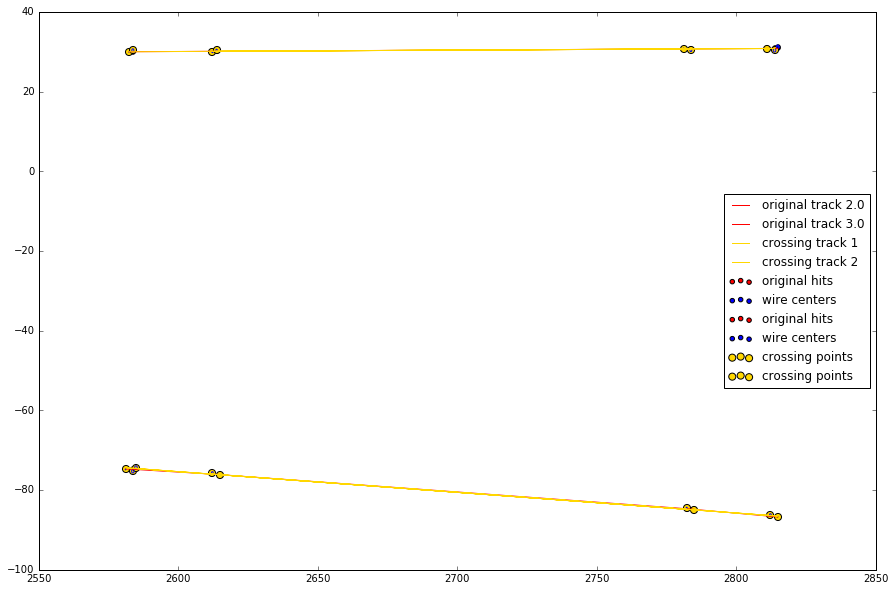

In [77]:
event_id = 1129
event = all_hits[all_hits.event==event_id]
ind = 0
plane_width = 0.85
n_min = 7
tracks, linking_table = loop_yz(event, n_min, plane_width, ind)
crossing_points = linking_table
    
event = modify_for_yz_analysis_1_2(event)
    
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1)
    
original_tracks = set(event.TrackID)
if -2 in original_tracks:
    original_tracks.remove(-2)

for j in original_tracks:
    track = event[event.TrackID==j]
    Wz = track.Wz.values
    Wy = track.Wy.values
    Z = track.Z.values
    Y = track.Y.values
    R = track.dist2Wire.values
    StrwR = 0.5 * np.ones(shape=(Z.shape[0],))

    # originl track and hits
    plt.plot(Z, Y, c='r', label='original track '+str(j))
    plt.scatter(Z, Y, c='r', label='original hits')

    # The wire centers and dist2wire
    plt.scatter(Wz, Wy, c='b', label='wire centers')
    for index in range(0, Z.shape[0]):
        circ = plt.Circle((Wz[index], Wy[index]), radius=R[index], color='b', fill=False)
        ax.add_patch(circ)

for j in tracks:
    # crossing point
    Z_crossing = np.array([event.loc[i].Wz for i in crossing_points[j]])
    Y_crossing = np.array([event.loc[i].Wy for i in crossing_points[j]])
    Y_line_crossing = Z_crossing * tracks[j][0] + tracks[j][1]

    plt.scatter(Z_crossing, Y_crossing, c='gold', label='crossing points', s=50)
    plt.plot(Z_crossing, Y_line_crossing , c='gold', label='crossing track '+str(j))
    N = len(crossing_points[j])
    dists = []
    for i in crossing_points[j]:
        dists.append(dist2Track((event.Wz[i], event.Wy[i]), tracks[j]) / event.dist2Wire[i])
    print "crossing track "+str(j)
    print "dists from crossing points to crossing track "+str(j)+":"
    print [dist2Track((event.Wz[k], event.Wy[k]), tracks[j]) for k in crossing_points[j]]
    print "dist2Wire from table:"
    print [event.dist2Wire[k] for k in crossing_points[j]]
    print "TrackID of each point:"
    print [event.TrackID[k] for k in crossing_points[j]]
    print [N, np.max(dists), np.min(dists), np.average(dists)]
    print clf.predict_proba([N, np.max(dists), np.min(dists), np.average(dists)])[0]

plt.legend(loc='best')
plt.show()

# new version

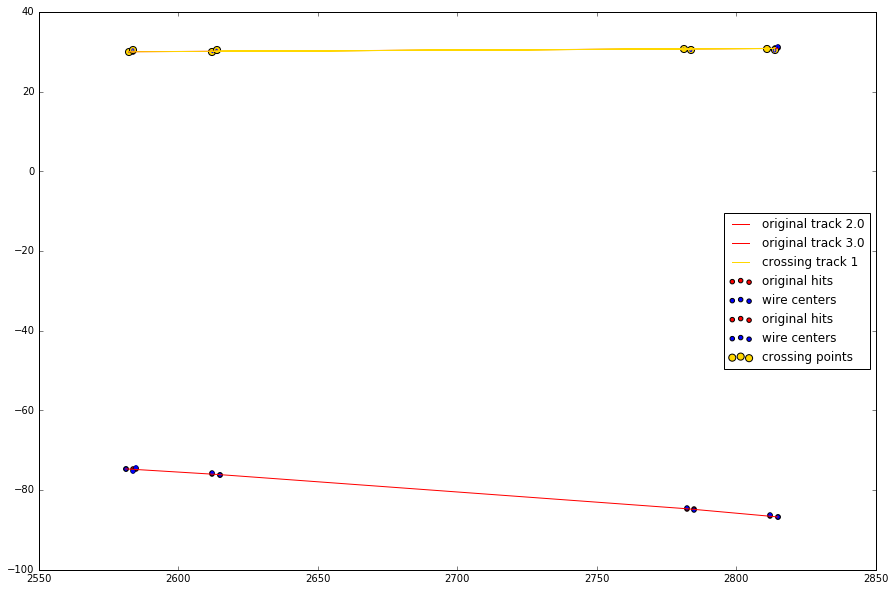

In [78]:
event_id = 1129
event = all_hits[all_hits.event==event_id]
ind = 0
plane_width = 0.85
n_min = 7
tracks, linking_table = loop_yz_new(event, n_min, plane_width, ind, clf)
crossing_points = linking_table
    
event = modify_for_yz_analysis_1_2(event)
    
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1)
    
original_tracks = set(event.TrackID)
if -2 in original_tracks:
    original_tracks.remove(-2)

for j in original_tracks:
    track = event[event.TrackID==j]
    Wz = track.Wz.values
    Wy = track.Wy.values
    Z = track.Z.values
    Y = track.Y.values
    R = track.dist2Wire.values
    StrwR = 0.5 * np.ones(shape=(Z.shape[0],))

    # originl track and hits
    plt.plot(Z, Y, c='r', label='original track '+str(j))
    plt.scatter(Z, Y, c='r', label='original hits')

    # The wire centers and dist2wire
    plt.scatter(Wz, Wy, c='b', label='wire centers')
    for index in range(0, Z.shape[0]):
        circ = plt.Circle((Wz[index], Wy[index]), radius=R[index], color='b', fill=False)
        ax.add_patch(circ)

for j in tracks:
    # crossing point
    Z_crossing = np.array([event.loc[i].Wz for i in crossing_points[j]])
    Y_crossing = np.array([event.loc[i].Wy for i in crossing_points[j]])
    Y_line_crossing = Z_crossing * tracks[j][0] + tracks[j][1]

    plt.scatter(Z_crossing, Y_crossing, c='gold', label='crossing points', s=50)
    plt.plot(Z_crossing, Y_line_crossing , c='gold', label='crossing track '+str(j))

plt.legend(loc='best')
plt.show()

# 1090

# old version

crossing track 1
dists from crossing points to crossing track 1:
[0.42729853788176952, 0.39096151564359366, 0.25676234428159767, 0.015475845864653561, 0.59848643225514686, 0.42795023865497495, 0.070577570696517891, 0.27810248730807108, 0.21977362127021635, 0.66319970578983067]
dist2Wire from table:
[0.052942047949809376, 0.39382243136902167, 0.32443233744348993, 0.018229165293931763, 0.42191855963382707, 0.23972096672219831, 0.38361442658886241, 0.16099009335021333, 0.32684811451480228, 0.086803736648640537]
TrackID of each point:
[2.0, 3.0, 3.0, 3.0, 2.0, 3.0, 2.0, 3.0, 3.0, 3.0]
[10, 8.0710617444731483, 0.1839804913597767, 2.4131922949375197]
[ 0.9  0.1]


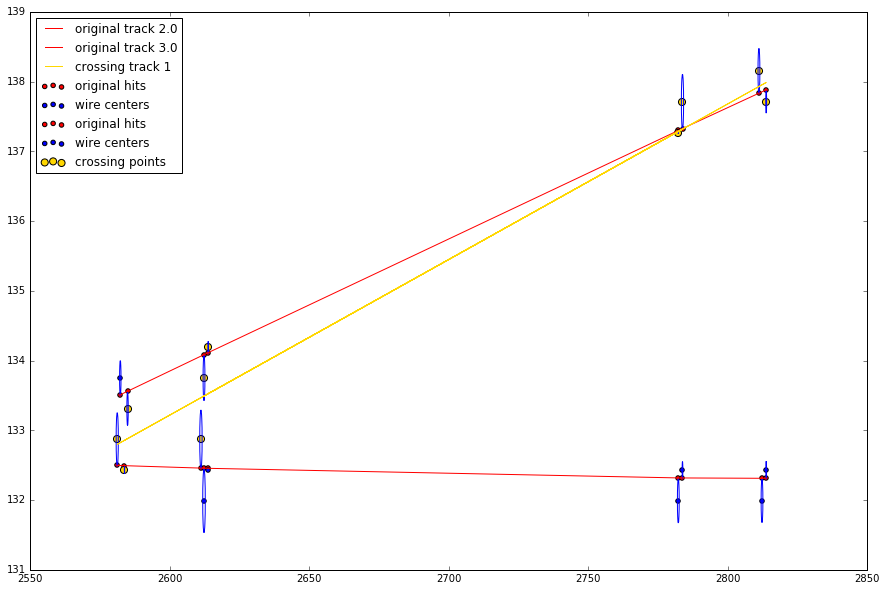

In [79]:
event_id = 1090
event = all_hits[all_hits.event==event_id]
ind = 0
plane_width = 0.85
n_min = 7
tracks, linking_table = loop_yz(event, n_min, plane_width, ind)
crossing_points = linking_table
    
event = modify_for_yz_analysis_1_2(event)
    
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1)
    
original_tracks = set(event.TrackID)
if -2 in original_tracks:
    original_tracks.remove(-2)

for j in original_tracks:
    track = event[event.TrackID==j]
    Wz = track.Wz.values
    Wy = track.Wy.values
    Z = track.Z.values
    Y = track.Y.values
    R = track.dist2Wire.values
    StrwR = 0.5 * np.ones(shape=(Z.shape[0],))

    # originl track and hits
    plt.plot(Z, Y, c='r', label='original track '+str(j))
    plt.scatter(Z, Y, c='r', label='original hits')

    # The wire centers and dist2wire
    plt.scatter(Wz, Wy, c='b', label='wire centers')
    for index in range(0, Z.shape[0]):
        circ = plt.Circle((Wz[index], Wy[index]), radius=R[index], color='b', fill=False)
        ax.add_patch(circ)

for j in tracks:
    # crossing point
    Z_crossing = np.array([event.loc[i].Wz for i in crossing_points[j]])
    Y_crossing = np.array([event.loc[i].Wy for i in crossing_points[j]])
    Y_line_crossing = Z_crossing * tracks[j][0] + tracks[j][1]

    plt.scatter(Z_crossing, Y_crossing, c='gold', label='crossing points', s=50)
    plt.plot(Z_crossing, Y_line_crossing , c='gold', label='crossing track '+str(j))
    N = len(crossing_points[j])
    dists = []
    for i in crossing_points[j]:
        dists.append(dist2Track((event.Wz[i], event.Wy[i]), tracks[j]) / event.dist2Wire[i])
    print "crossing track "+str(j)
    print "dists from crossing points to crossing track "+str(j)+":"
    print [dist2Track((event.Wz[k], event.Wy[k]), tracks[j]) for k in crossing_points[j]]
    print "dist2Wire from table:"
    print [event.dist2Wire[k] for k in crossing_points[j]]
    print "TrackID of each point:"
    print [event.TrackID[k] for k in crossing_points[j]]
    print [N, np.max(dists), np.min(dists), np.average(dists)]
    print clf.predict_proba([N, np.max(dists), np.min(dists), np.average(dists)])[0]

plt.legend(loc='best')
plt.show()

# new version

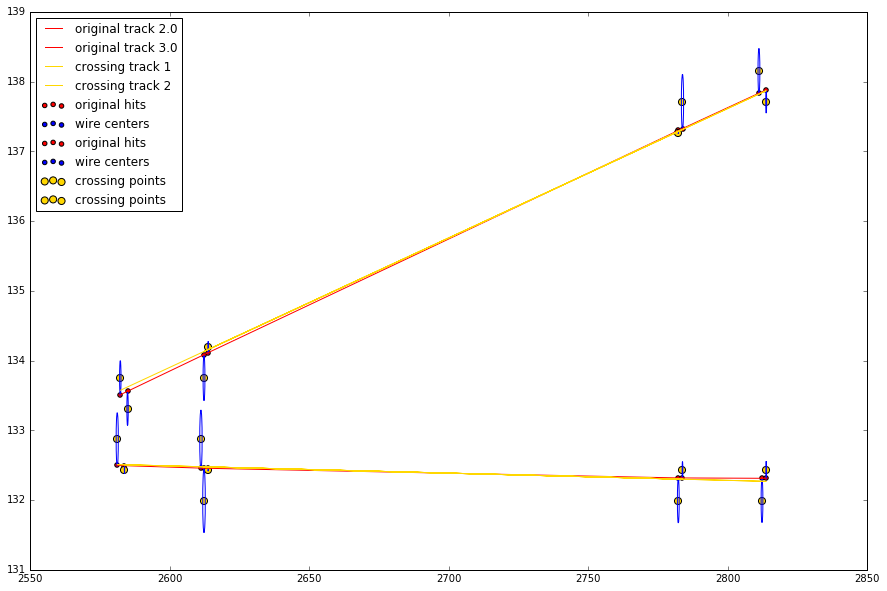

In [81]:
event_id = 1090
event = all_hits[all_hits.event==event_id]
ind = 0
plane_width = 0.85
n_min = 7
tracks, linking_table = loop_yz_new(event, n_min, plane_width, ind, clf)
crossing_points = linking_table
    
event = modify_for_yz_analysis_1_2(event)
    
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1)
    
original_tracks = set(event.TrackID)
if -2 in original_tracks:
    original_tracks.remove(-2)

for j in original_tracks:
    track = event[event.TrackID==j]
    Wz = track.Wz.values
    Wy = track.Wy.values
    Z = track.Z.values
    Y = track.Y.values
    R = track.dist2Wire.values
    StrwR = 0.5 * np.ones(shape=(Z.shape[0],))

    # originl track and hits
    plt.plot(Z, Y, c='r', label='original track '+str(j))
    plt.scatter(Z, Y, c='r', label='original hits')

    # The wire centers and dist2wire
    plt.scatter(Wz, Wy, c='b', label='wire centers')
    for index in range(0, Z.shape[0]):
        circ = plt.Circle((Wz[index], Wy[index]), radius=R[index], color='b', fill=False)
        ax.add_patch(circ)

for j in tracks:
    # crossing point
    Z_crossing = np.array([event.loc[i].Wz for i in crossing_points[j]])
    Y_crossing = np.array([event.loc[i].Wy for i in crossing_points[j]])
    Y_line_crossing = Z_crossing * tracks[j][0] + tracks[j][1]

    plt.scatter(Z_crossing, Y_crossing, c='gold', label='crossing points', s=50)
    plt.plot(Z_crossing, Y_line_crossing , c='gold', label='crossing track '+str(j))

plt.legend(loc='best')
plt.show()